# 勾配法と誤差逆伝播法
ニューラルネットワークにおいて，効率よく各重みの勾配を推定することで貢献度割り当て問題を解決する方法が**誤差逆伝播法** (backpropagation) である．本節では入力層，隠れ層，出力層からなる多層ニューラルネットワークを実装し，誤差逆伝播法による勾配推定を用いて学習を行う．

本書では誤差逆伝播法を用いない学習法を実施することも考慮し，数式と対応するような実装を行う．そのため，Deep Learningライブラリ (PyTorch, Flux.jl等) のようにLayerを定義し，それを繋げてモデルを定義するということや計算グラフの構築は行わない．

Direct Feedback Alignment Provides Learning in Deep Neural Networks

並列処理で重みの更新を行うことができる．

In [1]:
using Base: @kwdef
#using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, PyPlot, ProgressMeter
#using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter
#using BenchmarkTools; @btime
rc("axes.spines", top=false, right=false)

活性化関数 (activation function) の構造体を`ActivationFunction` と定義する．この構造体には`forward` と `backward`の2種類の関数フィールド (field; 構造体の要素のこと) を持たせておく．2種類の関数はそれぞれ順伝播時と逆伝播時に使用する．

In [2]:
struct ActivationFunction
    forward::Function   # function for forward propagation
    backward::Function  # function for back-propagation
end

また，次のコードにより，構造体のインスタンスを関数として使用できるようにしておく．これはcallable objectと呼ばれる．

In [3]:
(f::ActivationFunction)(x) = f.forward(x)

代表的な活性化関数を紹介する．なお，`backward` における `y` は `forward` での出力に対応する．これは活性化関数を作用させる前の変数 ($x$であり，膜電位に対応する) を保持しておかなくても良いようにするためである．

シグモイド関数 (sigmoid function) あるいはロジスティック関数 (logistic function) の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{1}{1+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{e^{-x}}{(1+e^{-x})^2}= y\cdot (1-y)\\
\end{align}
$$

tanh関数の場合，

$$
\begin{align}
&\textrm{forward: } y = \frac{e^x-e^{-x}}{e^x+e^{-x}}\\
&\textrm{backward: } \frac{dy}{dx} =\frac{(e^x+e^{-x})(e^x+e^{-x})-(e^x-e^{-x})(e^x-e^{-x})}{(e^x+e^{-x})^2}= 1-y^2\\
\end{align}
$$

ReLU関数 (rectified linear unit function, 正規化線形関数) あるいはランプ関数 (ramp function)の場合，

$$
\begin{align}
&\textrm{forward: } y = \max(x, 0)\\
&\textrm{backward: } \frac{dy}{dx} = \mathbf{1}_{x > 0}(x) = \mathbf{1}_{y > 0}(y)\\
\end{align}
$$

ただし，$\max(a, b)$は, $a, b$のうち，大きい値を返す関数である．また，$\mathbf{1}_{A}(x)$ は指示関数 (indicator function)であり，$x\in A$ ならば $\mathbf{1}_A(x)=1$ であり，それ以外の場合は $\mathbf{1}_A(x)=0$ となる関数である．ReLU関数は $x=0$ で折れ曲がるが，その他では線形であるため，区分線形関数 (piecewise linear function) の一種であると言える．

これらの活性化関数を構造体 `ActivationFunction`を用いて実装する．

In [4]:
Sigmoid = ActivationFunction(
    x -> 1.0 ./ (1.0 .+ exp.(-x)),
    y -> y .* (1 .- y)
)

Tanh = ActivationFunction(
    x -> tanh.(x),
    y -> 1 .- y .^ 2
)

Relu = ActivationFunction(
    x -> max.(0, x),
    y -> y .> 0
)

Identity = ActivationFunction(
    x -> x, # or use `identity` function
    y -> fill!(similar(y), 1)
);

Softplus = ActivationFunction(
    x -> log.(1 .+ exp.(x)),
    y -> (exp.(y) .- 1) ./ exp.(y)
    )

ActivationFunction(var"#17#19"(), var"#18#20"())

ニューラルネットワークのパラメータを保持する構造体を定義する．

In [5]:
abstract type NeuralNet end
(f::NeuralNet)(x) = forward!(f, x)

ニューラルネットワーク内の学習可能なパラメータ (learnable parameter) を保持する構造体を定義する．各パラメータはそれ自体の値 (value) と損失関数に対する勾配 (gradient) を持つ．

In [6]:
mutable struct Param
    v::Array
    grad::Array

    Param(value) = new(value, zero(value))
end

In [7]:
struct MLP <: NeuralNet
    L::Int # num. of layers
    W::Vector{Param}; b::Vector{Param}   # weights and bias
    B::Vector{Array} # backward weight
    z::Vector{Array}; δ::Vector{Array}   # state of forward/backward activity
    f::Vector{ActivationFunction} # activation functions of layers

    function MLP(n_units::Vector{Int}; f_hid::ActivationFunction=Sigmoid, f_out::ActivationFunction=Identity, init_type="He")
        L = length(n_units) - 1
        # initialization of parameters
        if init_type == "He"
            W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/n_units[l])) for l in 1:L] # He
            B = [2 * (rand(n_units[l], n_units[end]) .- 0.5) * sqrt(6/n_units[l]) for l in 1:L] # He
        else
            W = [Param(2 * (rand(n_units[l], n_units[l+1]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1]))) for l in 1:L] # Xavier
            B = [2 * (rand(n_units[l], n_units[end]) .- 0.5) * sqrt(6/(n_units[l]+n_units[l+1])) for l in 1:L] # Xavier
        end
        b = [Param(zeros(1, n_units[l+1])) for l in 1:L]
        
        # initialization of forward / backward states
        z, δ = Vector{Array}(undef, L+1), Vector{Array}(undef, L)
        f = vcat([repeat([f_hid], L-1)..., f_out])
        new(L, W, b, B, z, δ, f)
    end
end

struct `MLP`を用意し，**重みの初期化(weight initialization)** を行う同名の関数`MLP`を用意する．重みの初期化に関しては，各層の出力および勾配の分散が一定となるような初期化をすることで学習が進行することが知られている．出力は活性化関数に依存するため，初期化についても活性化関数に応じて変更することが推奨され，sigmoid関数やtanh関数を用いる場合はXavierの初期化 \citep{Glorot2010-iu}，ReLU関数を用いる場合はHeの初期化 \citep{He2015-fs} が用いられる．入力ユニット数を $n_{\textrm{in}}$, 出力ユニット数を $n_{\textrm{out}}$ とすると，Xavierの初期化では重み $w$ の平均が0, 分散が $\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}$ となるように一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}, \sqrt{\frac{6}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}+n_{\textrm{out}}}}\right)$ 等から重みをサンプリングする．Heの初期化ではReLUを用いる場合，重み $w$ の平均が0, 分散が$\frac{2}{n_{\textrm{in}}}$ あるいは $\frac{2}{n_{\textrm{out}}}$ となるようにし，前者の分散を使用する場合は一様分布 $U\left(-\sqrt{\frac{6}{n_{\textrm{in}}}}, \sqrt{\frac{6}{n_{\textrm{in}}}}\right)$ や正規分布 $\mathcal{N}\left(0, \sqrt{\frac{2}{n_{\textrm{in}}}}\right)$ 等から重みをサンプリングする．

### 順伝播 (forward propagation)
$f(\cdot)$を活性化関数とする．順伝播(feedforward propagation)は以下のようになる．$(\ell=1,\ldots,L)$

$$
\begin{align}
\text{入力層 : }&\mathbf{z}_1=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell\\
&\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}_{L+1}
\end{align}
$$

実装における取り回しの都合上，以下では$f:=f_\ell\ (1, \ldots, L-1)$ とし，$g:=f_{L}$ は損失関数において記述されることとする．以下では`z[l]`は$\mathbf{z}_\ell \ (1, \ldots, L)$に対応するが，`z[L+1]`は$\mathbf{z}_{L+1}$ではなく$\mathbf{a}_{L}$に対応することに注意．

とするか？混乱をきたしかねないし，余計な計算が増える．softmaxをどうするか．

In [8]:
# forward computation of MLP
function forward!(mlp::MLP, x::Array)
    (;L, f, W, b, z) = mlp
    z[1] = x # input (n_batch x n_neurons)
    for l in 1:L
        z[l+1] = f[l](z[l] * W[l].v .+ b[l].v) # hidden layers
    end
    return z[L+1] # output
end

forward! (generic function with 1 method)

`W[l].v` は`l`番目の`Param`のインスタンスにおける`v`を取り出す操作である．

### 逆伝播 (backward propagation)
ニューラルネットワークの学習 (learning) あるいは訓練 (training) とは，目的関数 (objective function) あるいは損失関数 (loss function) と呼ばれる評価指標を可能な限り小さく (場合によっては大きく) するようなパラメータ集合 $\Theta = \{W_\ell, b_\ell\}_{\ell=1}^{L}$ を求める過程のことである．学習においてパラメータを最適化するアルゴリズムを**オプティマイザ** (optimizer) という．オプティマイザは多数提案されており，代表的なものを後ほど紹介する．まず，最も単純なオプティマイザである **勾配降下法** (gradient descent; GD) を紹介する．勾配降下法では全データを用いてパラメータ $\theta \in \Theta$ の更新量 $\Delta \theta$ を 

$$
\Delta \theta = -\eta \frac{\partial \mathcal{L}_{\textrm{GD}}}{\partial \theta} = -\frac{\eta}{N} \sum_{i=1}^N \frac{\partial \mathcal{L}^{(i)}}{\partial \theta}
$$

として計算する (パラメータは$\theta\leftarrow \theta + \Delta \theta$により更新される)．ただし，$\mathcal{L}_{\textrm{GD}}:=\frac{1}{N}\sum_{i=1}^N \mathcal{L}^{(i)}$ であり，$\mathcal{L}^{(i)}$は$i$ 番目のサンプルに対する目的関数であり，$N$ は全データのサンプル数を意味する．$\eta$ は学習率 (learning rate) である．オプティマイザは一般的に勾配 $\dfrac{\partial \mathcal{L}}{\partial \theta}$ の計算を必要とする．この計算を効率よく行う手法が**誤差逆伝播法** (backpropagation) である．誤差逆伝播法は連鎖律 (chain rule; 合成関数の微分の関係式) を用いて導くことができる．$\mathbf{a}_\ell=W_\ell \mathbf{z}_\ell +\mathbf{b}_\ell$ および $\mathbf{z}_{\ell+1}=f_\ell\left(\mathbf{a}_\ell\right)$ であることを踏まえると，

$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}\\
\delta_L&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}\\
\mathbf{\delta}_\ell&:=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{\ell+1}} \frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_\ell}\\
&=\left(\frac{\partial \mathcal{L}}{\partial \mathbf{a}_{\ell+1}}\frac{\partial \mathbf{a}_{\ell+1}}{\partial \mathbf{z}_{\ell+1}}\right)\frac{\partial \mathbf{z}_{\ell+1}}{\partial \mathbf{a}_{\ell}}\\
&={W_{\ell+1}}^\top \delta_{\ell+1} \odot f_\ell^{\prime}\left(\mathbf{a}_{\ell}\right)\\
\frac{\partial \mathcal{L}}{\partial W_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial W_\ell}=\delta_\ell \mathbf{z}_\ell^\top\\
\frac{\partial \mathcal{L}}{\partial \mathbf{b}_\ell}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_\ell} \frac{\partial \mathbf{z}_\ell}{\partial \mathbf{a}_\ell} \frac{\partial \mathbf{a}_\ell}{\partial \mathbf{b}_\ell}=\delta_\ell
\end{align}
$$

が成り立つ．バッチ処理を考慮すると，行列を乗ずる順番が変わる．以下では$z=f(a), g(z)=f'(a)$として膜電位を使わず，発火率情報のみを使うようにしている．このようにできない関数もあるが，今回はこのように書き下せる活性化関数のみを扱う．

In [9]:
function backward!(mlp::MLP)
    (;L, W, b, B, z, δ, f) = mlp
    n_batch = size(z[1])[1]
    # backprop
    for l in L:-1:1
        if l < L
            δ[l] = δ[end] * B[l+1]' .* f[l].backward(z[l+1])
        end
        W[l].grad = z[l]' * δ[l] / n_batch
        b[l].grad = sum(δ[l], dims=1) / n_batch
    end
end

backward! (generic function with 1 method)

### 損失関数
回帰問題において，代表的に用いられるのが平均二乗誤差 (mean squared error) である．

$$
\begin{align}
\hat{\mathbf{y}} &= \mathbf{z}_{L+1}\\
\mathcal{L}&:=\frac{1}{2}\left\|\hat{\mathbf{y}}-\mathbf{y}\right\|^{2}\\
\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}&=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}}=\hat{\mathbf{y}}-\mathbf{y}\\
\delta_L&=\frac{\partial \mathcal{L}}{\partial \mathbf{a}_L}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}_{L+1}} \frac{\partial \mathbf{z}_{L+1}}{\partial \mathbf{a}_L}=\left(\hat{\mathbf{y}}-\mathbf{y}\right) \odot f_L^{\prime}\left(\mathbf{a}_L\right)\\
\end{align}
$$

In [10]:
function squared_error!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = sum(error .^ 2) / n_batch
    δ[end] = error .* f[end].backward(ŷ)
    return loss
end

squared_error! (generic function with 1 method)

2クラス分類で用いられるのがバイナリ交差エントロピー (binary cross entropy) である．

In [11]:
clog(x) = max(log(x), -1e2) # clamped log

function binary_crossentropy!(nn::NeuralNet, y::Array)
    (;z, δ, f) = nn
    @assert f[end] == Sigmoid # f[end] must be sigmoid function
    ŷ = z[end]
    n_batch = size(y)[1]
    error = ŷ - y
    loss = -sum(y .* clog.(ŷ) + (1 .- y) .* clog.(1 .- ŷ)) / n_batch
    δ[end] = error
    return loss
end

binary_crossentropy! (generic function with 1 method)

多クラス分類課題で用いられるのが，softmaxおよびcross entropy lossである．
softmax関数は $\mathbf{y} = \text{softmax}(\mathbf{z})$ とすると，各成分を以下のように定義される．

$$
\begin{equation}
y_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}
\end{equation}
$$

In [12]:
function softmax(x; dims=2)
    expx = exp.(x .- maximum(x, dims=dims))
    return expx ./ sum(expx, dims=dims)
end

Softmax = ActivationFunction(softmax, identity);

# t: labels (1 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Vector)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = length(t)
    idx = CartesianIndex.([(i, t[i]) for i in 1:n_batch])
    loss = -sum(clog.(ŷ[idx])) / n_batch
    grad = copy(ŷ)
    grad[idx] .-= 1
    δ[end] = grad / n_batch
    return loss
end

# t: probability (2 dims)
function cross_entropy_loss!(nn::NeuralNet, t::Array)
    (;z, δ, f) = nn
    @assert f[end] == Softmax # f[end] must be softmax function
    ŷ = z[end]
    n_batch = size(t)[1]
    loss = -sum(t .* clog.(ŷ)) / n_batch
    δ[end] = (ŷ - t) / n_batch
    return loss
end

cross_entropy_loss! (generic function with 2 methods)

Softmaxのbackwardは基本的に使用しないため，適当に`identity`関数などを入れておく．

### オプティマイザ
abstract typeとして`Optimizer`タイプを作成する．

In [13]:
abstract type Optimizer end

勾配降下法は$N$が大きい場合，あるいは1つのサンプルのデータサイズが大きい場合は非効率であるので，ニューラルネットワークの学習においては，データの部分集合であるミニバッチ (mini-bacth) を用いた **確率的勾配降下法** (stochastic gradient descent; SGD) が用いられる．
**確率的勾配降下法(stochastic gradient descent; SGD)** を実装する．

In [14]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    lr::FT=1e-2 # learning rate
end

function optimizer_update!(param::Param, optimizer::SGD; weight_decay=0)
    (;lr) = optimizer
    if weight_decay > 0
        param.grad += weight_decay * param.v
    end
    param.v -= lr * param.grad
end

optimizer_update! (generic function with 1 method)

次に**Adam** {cite:p}`Kingma2014-fm` を実装する．

In [15]:
# Adam optimizer
@kwdef mutable struct Adam <: Optimizer
    lr=1e-4; β1=0.9; β2=0.999; ϵ=1e-8
    ms=Dict(); vs=Dict();
end

# Adam optimizer
function optimizer_update!(param::Param, optimizer::Adam; weight_decay=0)
    (;lr, β1, β2, ϵ, ms, vs) = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zero(param.v), zero(param.v)
    end
    if weight_decay > 0
        param.v -= lr * weight_decay * param.v
    end
    m, v = ms[key], vs[key]
    m += (1 - β1) * (param.grad - m)
    v += (1 - β2) * (param.grad .* param.grad - v)
    param.v -= lr * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

重みのL2正則化 (Weight decay) を加える．正則化があることにより，実際のニューロンの活動を人工神経回路で再現できる研究も複数ある．バイアス項にはweight decayをしないため，optimizerの構造体の外からweight decayの値を与えることとする．

In [16]:
function optim_step!(nn::NeuralNet, optimizer::Optimizer; weight_decay=0)
    (;L, W, b) = nn
    # update weights
    for param in W
        optimizer_update!(param, optimizer, weight_decay=weight_decay)
    end

    # update bias (without weight decay)
    for param in b
        optimizer_update!(param, optimizer, weight_decay=0)
    end
end

optim_step! (generic function with 1 method)

In [17]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function; optimizer::Optimizer=SGD(), weight_decay=0)
    _ = nn(x)
    loss = loss_fun(nn, y)
    backward!(nn)
    optim_step!(nn, optimizer, weight_decay=weight_decay) # update params
    return loss
end

train_step! (generic function with 1 method)

## MNIST

`MNIST` の代わりに`FashionMNIST` を用いることもできる．MNISTは易しい課題であるため，MNISTを訓練できるからと言って複雑な課題でも機能する保証はない．とは言え，基本的なデータセットであるため，

In [18]:
using MLDatasets

In [19]:
trainset = MNIST(:train)
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

初回実行時はデータセットのダウンロードを行うか`[y/n]` (yes/no) の入力を求められるので`y`と入力する．

In [20]:
length(trainset)

60000

In [21]:
trainset[1]  # return first observation as a NamedTuple

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = 5)

In [22]:
X_train, y_train = trainset[:] # return all observations
y_train .+= 1; # 0-9 to 1-10

In [23]:
# training θeter
n_traindata = 20000 #or length(trainset)
n_batch = 100 # batch size
n_iter_per_epoch = round(Int, n_traindata/n_batch)
n_epoch = 200; # number of epoch

In [24]:
n_classes = 10
n_hid = 128
nn1 = MLP([28^2, n_hid, n_hid, n_classes], f_hid=Tanh, f_out=Softmax, init_type="Xavier")
loss_fun1 = cross_entropy_loss!

lr = 0.01  # learning rate
weight_decay = 0#.1 # weight decay (L2 norm) strength
optimizer1 = Adam(lr=lr); # SGD(lr=lr)#

In [25]:
cosine_distance(x,y) = dot(x,y)/(norm(x)*norm(y))

cosine_distance (generic function with 1 method)

In [26]:
error_arr = zeros(n_epoch); # memory array of each epoch error
#cdist = zeros(nn1.L, n_epoch)
@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = Matrix(reshape(X_train[:, :, idx], (:, n_batch))'), y_train[idx]
        loss = train_step!(nn1, x, y, loss_fun1, optimizer=optimizer1, weight_decay=weight_decay)
        error_arr[e] += loss
    end
    """
    for i in 1:nn1.L
        cdist[i, e] = cosine_distance(nn1.W[i].v[:], nn1.B[i][:])
    end
    """
    error_arr[e] /= n_traindata
    println("[$(e)/$(n_epoch)] train loss: $(error_arr[e])")
end

[1/200] train loss: 0.008458994167675347
[2/200] train loss: 0.004780796274549796

Training...   1%|█                                       |  ETA: 0:10:47

Training...   2%|█                                       |  ETA: 0:09:15

[3/200] train loss: 0.004124165190986861


Training...   2%|█                                       |  ETA: 0:07:48

[4/200] train loss: 0.003939767398168719


Training...   2%|██                                      |  ETA: 0:06:54

[5/200] train loss: 0.0034481260811446454


Training...   3%|██                                      |  ETA: 0:06:17

[6/200] train loss: 0.0031328355177470332


Training...   4%|██                                      |  ETA: 0:05:50

[7/200] train loss: 0.003058250367135645


Training...   4%|██                                      |  ETA: 0:05:29

[8/200] train loss: 0.002850681743004299


Training...   4%|██                                      |  ETA: 0:05:14

[9/200] train loss: 0.00261713903226635


Training...   5%|███                                     |  ETA: 0:05:00

[10/200] train loss: 0.00243514981805114


Training...   6%|███                                     |  ETA: 0:04:49

[11/200] train loss: 0.0022976409404966143


Training...   6%|███                                     |  ETA: 0:04:40

[12/200] train loss: 0.002022189607956491


Training...   6%|███                                     |  ETA: 0:04:32

[13/200] train loss: 0.0019762142810304147


Training...   7%|███                                     |  ETA: 0:04:23

[14/200] train loss: 0.0017907387809339074


Training...   8%|████                                    |  ETA: 0:04:17

[15/200] train loss: 0.0015935487938760597


Training...   8%|████                                    |  ETA: 0:04:10

[16/200] train loss: 0.001608276462139824


Training...   8%|████                                    |  ETA: 0:04:05

[17/200] train loss: 0.001320591538372672


Training...   9%|████                                    |  ETA: 0:04:00

[18/200] train loss: 0.0014143808805228597


Training...  10%|████                                    |  ETA: 0:03:55

[19/200] train loss: 0.0014351841426744549


Training...  10%|█████                                   |  ETA: 0:03:51

[20/200] train loss: 0.0011412680875912012


Training...  10%|█████                                   |  ETA: 0:03:47

[21/200] train loss: 0.0010221400183135683


Training...  11%|█████                                   |  ETA: 0:03:43

[22/200] train loss: 0.0009512076832490854


Training...  12%|█████                                   |  ETA: 0:03:39

[23/200] train loss: 0.0009535658291325472


Training...  12%|█████                                   |  ETA: 0:03:36

[24/200] train loss: 0.0008850251803265489


Training...  12%|██████                                  |  ETA: 0:03:33

[25/200] train loss: 0.0007567742610762491


Training...  13%|██████                                  |  ETA: 0:03:29

[26/200] train loss: 0.0007872110253117468


Training...  14%|██████                                  |  ETA: 0:03:26

[27/200] train loss: 0.0006214370614090993


Training...  14%|██████                                  |  ETA: 0:03:24

[28/200] train loss: 0.0006768539526344788


Training...  14%|██████                                  |  ETA: 0:03:21

[29/200] train loss: 0.0006714867421738316


Training...  15%|███████                                 |  ETA: 0:03:18

[30/200] train loss: 0.0006203218947910214


Training...  16%|███████                                 |  ETA: 0:03:15

[31/200] train loss: 0.0005286628287737652


Training...  16%|███████                                 |  ETA: 0:03:13

[32/200] train loss: 0.0004096217150153066


Training...  16%|███████                                 |  ETA: 0:03:11

[33/200] train loss: 0.00050141985225898


Training...  17%|███████                                 |  ETA: 0:03:08

[34/200] train loss: 0.00041288084397727014


Training...  18%|████████                                |  ETA: 0:03:06

[35/200] train loss: 0.00034313182557192776


Training...  18%|████████                                |  ETA: 0:03:04

[36/200] train loss: 0.00034773665493793946


Training...  18%|████████                                |  ETA: 0:03:02

[37/200] train loss: 0.0002725459458161732


Training...  19%|████████                                |  ETA: 0:03:00

[38/200] train loss: 0.0002607478738191128


[39/200] train loss: 0.00019553755564788913


Training...  20%|█████████                               |  ETA: 0:02:56

[40/200] train loss: 0.00019730344059903354


Training...  20%|█████████                               |  ETA: 0:02:55

[41/200] train loss: 0.0001254632688223093


Training...  21%|█████████                               |  ETA: 0:02:53

[42/200] train loss: 0.00012251080550367138


Training...  22%|█████████                               |  ETA: 0:02:52

[43/200] train loss: 9.312151769468945e-5


Training...  22%|█████████                               |  ETA: 0:02:50

[44/200] train loss: 5.392639163212689e-5


Training...  22%|██████████                              |  ETA: 0:02:49

[45/200] train loss: 0.00013121760314352212


Training...  23%|██████████                              |  ETA: 0:02:47

[46/200] train loss: 0.00010771988610895684


Training...  24%|██████████                              |  ETA: 0:02:46

[47/200] train loss: 0.00012473974181306197


Training...  24%|██████████                              |  ETA: 0:02:44

[48/200] train loss: 0.00013755532933690647


Training...  24%|██████████                              |  ETA: 0:02:43

[49/200] train loss: 7.488746968499595e-5


Training...  25%|███████████                             |  ETA: 0:02:42

[50/200] train loss: 8.526350553189854e-5


Training...  26%|███████████                             |  ETA: 0:02:41

[51/200] train loss: 9.722336626298855e-5


Training...  26%|███████████                             |  ETA: 0:02:39

[52/200] train loss: 5.812009961050537e-5


Training...  26%|███████████                             |  ETA: 0:02:38

[53/200] train loss: 5.773810970582819e-5


Training...  27%|███████████                             |  ETA: 0:02:36

[54/200] train loss: 6.507832796348603e-5


[55/200] train loss: 4.317519150239806e-5


Training...  28%|████████████                            |  ETA: 0:02:34

[56/200] train loss: 9.809118620165083e-5


Training...  28%|████████████                            |  ETA: 0:02:33

[57/200] train loss: 8.72249581139611e-5


Training...  29%|████████████                            |  ETA: 0:02:31

[58/200] train loss: 2.919835238749055e-5


Training...  30%|████████████                            |  ETA: 0:02:30

[59/200] train loss: 3.455619078322654e-5


Training...  30%|█████████████                           |  ETA: 0:02:29

[60/200] train loss: 4.302284503914863e-5


Training...  30%|█████████████                           |  ETA: 0:02:27

[61/200] train loss: 6.510605674652734e-5


Training...  31%|█████████████                           |  ETA: 0:02:26

[62/200] train loss: 3.9977759038769914e-5


Training...  32%|█████████████                           |  ETA: 0:02:25

[63/200] train loss: 0.00010104904438621897


Training...  32%|█████████████                           |  ETA: 0:02:24

[64/200] train loss: 5.9885478509231384e-5


Training...  32%|██████████████                          |  ETA: 0:02:22

[65/200] train loss: 6.699840376381402e-5


Training...  33%|██████████████                          |  ETA: 0:02:21

[66/200] train loss: 0.0001410066343199314


Training...  34%|██████████████                          |  ETA: 0:02:20

[67/200] train loss: 4.422690013932938e-5


Training...  34%|██████████████                          |  ETA: 0:02:19

[68/200] train loss: 6.182087643283695e-5


Training...  34%|██████████████                          |  ETA: 0:02:17

[69/200] train loss: 0.00010891688535493505


Training...  35%|███████████████                         |  ETA: 0:02:16

[70/200] train loss: 5.387118078182812e-5


Training...  36%|███████████████                         |  ETA: 0:02:15

[71/200] train loss: 5.683902436902465e-5


Training...  36%|███████████████                         |  ETA: 0:02:14

[72/200] train loss: 2.311901084350437e-5


Training...  36%|███████████████                         |  ETA: 0:02:13

[73/200] train loss: 3.926118430780695e-5


Training...  37%|███████████████                         |  ETA: 0:02:11

[74/200] train loss: 2.6501232675988444e-5


Training...  38%|████████████████                        |  ETA: 0:02:10

[75/200] train loss: 2.6878027061459914e-5


Training...  38%|████████████████                        |  ETA: 0:02:09

[76/200] train loss: 1.3139679958041062e-5


Training...  38%|████████████████                        |  ETA: 0:02:08

[77/200] train loss: 3.259133078826456e-5


Training...  39%|████████████████                        |  ETA: 0:02:07

[78/200] train loss: 6.394203686460813e-6


Training...  40%|████████████████                        |  ETA: 0:02:05

[79/200] train loss: 6.086381087337925e-6


Training...  40%|█████████████████                       |  ETA: 0:02:04

[80/200] train loss: 6.7660938281373705e-6


Training...  40%|█████████████████                       |  ETA: 0:02:03

[81/200] train loss: 1.479027326043507e-5


Training...  41%|█████████████████                       |  ETA: 0:02:02

[82/200] train loss: 4.884498515131893e-7


Training...  42%|█████████████████                       |  ETA: 0:02:01

[83/200] train loss: 4.704730118689897e-6


Training...  42%|█████████████████                       |  ETA: 0:02:00

[84/200] train loss: 9.354061975718252e-6


Training...  42%|██████████████████                      |  ETA: 0:01:59

[85/200] train loss: 2.1025660754079594e-5


Training...  43%|██████████████████                      |  ETA: 0:01:57

[86/200] train loss: 2.8457609626506378e-6


Training...  44%|██████████████████                      |  ETA: 0:01:56

[87/200] train loss: 8.397788049874999e-6


Training...  44%|██████████████████                      |  ETA: 0:01:55

[88/200] train loss: 5.964109876587859e-6


Training...  44%|██████████████████                      |  ETA: 0:01:54

[89/200] train loss: 1.1368918227401966e-5


Training...  45%|███████████████████                     |  ETA: 0:01:53

[90/200] train loss: 4.660019354662448e-6


Training...  46%|███████████████████                     |  ETA: 0:01:52

[91/200] train loss: 1.3740265476103212e-5


Training...  46%|███████████████████                     |  ETA: 0:01:51

[92/200] train loss: 2.0768189401667501e-7


Training...  46%|███████████████████                     |  ETA: 0:01:50

[93/200] train loss: 5.338947231460222e-9


Training...  47%|███████████████████                     |  ETA: 0:01:49

[94/200] train loss: 1.2995445071049221e-9


Training...  48%|████████████████████                    |  ETA: 0:01:48

[95/200] train loss: 1.0503721012288633e-9


Training...  48%|████████████████████                    |  ETA: 0:01:47

[96/200] train loss: 9.080715746716019e-10


Training...  48%|████████████████████                    |  ETA: 0:01:46

[97/200] train loss: 8.115013417150961e-10


Training...  49%|████████████████████                    |  ETA: 0:01:45

[98/200] train loss: 7.39856266929771e-10


Training...  50%|████████████████████                    |  ETA: 0:01:44

[99/200] train loss: 6.836841608586636e-10


Training...  50%|█████████████████████                   |  ETA: 0:01:43

[100/200] train loss: 6.379616926825739e-10


Training...  50%|█████████████████████                   |  ETA: 0:01:42

[101/200] train loss: 5.997258900417942e-10


Training...  51%|█████████████████████                   |  ETA: 0:01:41

[102/200] train loss: 5.670923730100188e-10


Training...  52%|█████████████████████                   |  ETA: 0:01:39

[103/200] train loss: 5.387925759137261e-10


Training...  52%|█████████████████████                   |  ETA: 0:01:38

[104/200] train loss: 5.139338534675113e-10


Training...  52%|██████████████████████                  |  ETA: 0:01:37

[105/200] train loss: 4.918655472519434e-10


Training...  53%|██████████████████████                  |  ETA: 0:01:36

[106/200] train loss: 4.720996053859551e-10


Training...  54%|██████████████████████                  |  ETA: 0:01:35

[107/200] train loss: 4.542611683257527e-10


Training...  54%|██████████████████████                  |  ETA: 0:01:34

[108/200] train loss: 4.380565252935641e-10


Training...  54%|██████████████████████                  |  ETA: 0:01:33

[109/200] train loss: 4.232516068833644e-10


Training...  55%|███████████████████████                 |  ETA: 0:01:32

[110/200] train loss: 4.0965711983661467e-10


Training...  56%|███████████████████████                 |  ETA: 0:01:31

[111/200] train loss: 3.9711801104988384e-10


Training...  56%|███████████████████████                 |  ETA: 0:01:30

[112/200] train loss: 3.855058343313972e-10


Training...  56%|███████████████████████                 |  ETA: 0:01:29

[113/200] train loss: 3.7471311359079155e-10


Training...  57%|███████████████████████                 |  ETA: 0:01:28

[114/200] train loss: 3.6464910933812367e-10


Training...  58%|████████████████████████                |  ETA: 0:01:27

[115/200] train loss: 3.552365911312386e-10


Training...  58%|████████████████████████                |  ETA: 0:01:26

[116/200] train loss: 3.4640934358694367e-10


Training...  58%|████████████████████████                |  ETA: 0:01:25

[117/200] train loss: 3.3811021576936483e-10


Training...  59%|████████████████████████                |  ETA: 0:01:24

[118/200] train loss: 3.3028957879078493e-10


Training...  60%|████████████████████████                |  ETA: 0:01:22

[119/200] train loss: 3.229040939223504e-10


Training...  60%|█████████████████████████               |  ETA: 0:01:21

[120/200] train loss: 3.159157195641835e-10


Training...  60%|█████████████████████████               |  ETA: 0:01:20

[121/200] train loss: 3.092909041078311e-10


Training...  61%|█████████████████████████               |  ETA: 0:01:19

[122/200] train loss: 3.0299992474114206e-10


Training...  62%|█████████████████████████               |  ETA: 0:01:18

[123/200] train loss: 2.970163418868345e-10


Training...  62%|█████████████████████████               |  ETA: 0:01:17

[124/200] train loss: 2.913165460713863e-10


Training...  62%|██████████████████████████              |  ETA: 0:01:16

[125/200] train loss: 2.858793791904894e-10


Training...  63%|██████████████████████████              |  ETA: 0:01:15

[126/200] train loss: 2.8068581612704016e-10


[127/200] train loss: 2.757186956303064e-10


Training...  64%|██████████████████████████              |  ETA: 0:01:13

[128/200] train loss: 2.7096249170169497e-10


Training...  64%|██████████████████████████              |  ETA: 0:01:12

[129/200] train loss: 2.664031183809813e-10


Training...  65%|███████████████████████████             |  ETA: 0:01:11

[130/200] train loss: 2.6202776243256724e-10


Training...  66%|███████████████████████████             |  ETA: 0:01:10

[131/200] train loss: 2.5782473916314527e-10


Training...  66%|███████████████████████████             |  ETA: 0:01:09

[132/200] train loss: 2.5378336781946556e-10


Training...  66%|███████████████████████████             |  ETA: 0:01:08

[133/200] train loss: 2.498938634119086e-10


Training...  67%|███████████████████████████             |  ETA: 0:01:07

[134/200] train loss: 2.461472424524471e-10


Training...  68%|████████████████████████████            |  ETA: 0:01:06

[135/200] train loss: 2.425352406257915e-10


Training...  68%|████████████████████████████            |  ETA: 0:01:05

[136/200] train loss: 2.390502405069526e-10


Training...  68%|████████████████████████████            |  ETA: 0:01:03

[137/200] train loss: 2.356852080298751e-10


Training...  69%|████████████████████████████            |  ETA: 0:01:02

[138/200] train loss: 2.3243363641236052e-10


Training...  70%|████████████████████████████            |  ETA: 0:01:01

[139/200] train loss: 2.2928949652589908e-10


Training...  70%|█████████████████████████████           |  ETA: 0:01:00

[140/200] train loss: 2.2624719290279588e-10


[141/200] train loss: 2.233015245278751e-10


Training...  71%|█████████████████████████████           |  ETA: 0:00:58

[142/200] train loss: 2.2044764998680117e-10


Training...  72%|█████████████████████████████           |  ETA: 0:00:57

[143/200] train loss: 2.1768105618824305e-10


Training...  72%|█████████████████████████████           |  ETA: 0:00:56

[144/200] train loss: 2.1499753044098724e-10


Training...  72%|██████████████████████████████          |  ETA: 0:00:55

[145/200] train loss: 2.123931353370384e-10


Training...  73%|██████████████████████████████          |  ETA: 0:00:54

[146/200] train loss: 2.0986418614899054e-10


Training...  74%|██████████████████████████████          |  ETA: 0:00:53

[147/200] train loss: 2.0740723049968265e-10


Training...  74%|██████████████████████████████          |  ETA: 0:00:52

[148/200] train loss: 2.0501902993093745e-10


Training...  74%|██████████████████████████████          |  ETA: 0:00:51

[149/200] train loss: 2.0269654327067483e-10


Training...  75%|███████████████████████████████         |  ETA: 0:00:50

[150/200] train loss: 2.0043691155059669e-10


Training...  76%|███████████████████████████████         |  ETA: 0:00:49

[151/200] train loss: 1.9823744429263836e-10


Training...  76%|███████████████████████████████         |  ETA: 0:00:48

[152/200] train loss: 1.9609560701902374e-10


Training...  76%|███████████████████████████████         |  ETA: 0:00:47

[153/200] train loss: 1.9400900993812213e-10


Training...  77%|███████████████████████████████         |  ETA: 0:00:46

[154/200] train loss: 1.9197539752860813e-10


Training...  78%|████████████████████████████████        |  ETA: 0:00:45

[155/200] train loss: 1.8999263910118948e-10


Training...  78%|████████████████████████████████        |  ETA: 0:00:44

[156/200] train loss: 1.8805872009165374e-10


Training...  78%|████████████████████████████████        |  ETA: 0:00:43

[157/200] train loss: 1.8617173415284625e-10


Training...  79%|████████████████████████████████        |  ETA: 0:00:42

[158/200] train loss: 1.8432987581287303e-10


Training...  80%|████████████████████████████████        |  ETA: 0:00:41

[159/200] train loss: 1.8253143381027315e-10


Training...  80%|█████████████████████████████████       |  ETA: 0:00:40

[160/200] train loss: 1.8077478489482908e-10


Training...  80%|█████████████████████████████████       |  ETA: 0:00:39

[161/200] train loss: 1.790583881637338e-10


Training...  81%|█████████████████████████████████       |  ETA: 0:00:38

[162/200] train loss: 1.773807798008325e-10


Training...  82%|█████████████████████████████████       |  ETA: 0:00:37

[163/200] train loss: 1.75740568244697e-10


Training...  82%|█████████████████████████████████       |  ETA: 0:00:36

[164/200] train loss: 1.74136429694654e-10


Training...  82%|██████████████████████████████████      |  ETA: 0:00:35

[165/200] train loss: 1.725671039985736e-10


Training...  83%|██████████████████████████████████      |  ETA: 0:00:34

[166/200] train loss: 1.710313907829102e-10


Training...  84%|██████████████████████████████████      |  ETA: 0:00:33

[167/200] train loss: 1.69528145889837e-10


Training...  84%|██████████████████████████████████      |  ETA: 0:00:32

[168/200] train loss: 1.6805627808761112e-10


Training...  84%|██████████████████████████████████      |  ETA: 0:00:31

[169/200] train loss: 1.666147459931599e-10


Training...  85%|███████████████████████████████████     |  ETA: 0:00:30

[170/200] train loss: 1.652025552030612e-10


Training...  86%|███████████████████████████████████     |  ETA: 0:00:29

[171/200] train loss: 1.6381875563691064e-10


Training...  86%|███████████████████████████████████     |  ETA: 0:00:28

[172/200] train loss: 1.6246243905832869e-10


Training...  86%|███████████████████████████████████     |  ETA: 0:00:27

[173/200] train loss: 1.6113273674940273e-10


Training...  87%|███████████████████████████████████     |  ETA: 0:00:26

[174/200] train loss: 1.598288173737577e-10


Training...  88%|████████████████████████████████████    |  ETA: 0:00:25

[175/200] train loss: 1.585498849164571e-10


Training...  88%|████████████████████████████████████    |  ETA: 0:00:24

[176/200] train loss: 1.5729517684406238e-10


Training...  88%|████████████████████████████████████    |  ETA: 0:00:23

[177/200] train loss: 1.5606396229145107e-10


Training...  89%|████████████████████████████████████    |  ETA: 0:00:22

[178/200] train loss: 1.5485554045053054e-10


Training...  90%|████████████████████████████████████    |  ETA: 0:00:21

[179/200] train loss: 1.536692389855977e-10


Training...  90%|█████████████████████████████████████   |  ETA: 0:00:20

[180/200] train loss: 1.525044125857583e-10


Training...  90%|█████████████████████████████████████   |  ETA: 0:00:19

[181/200] train loss: 1.5136044161365795e-10


Training...  91%|█████████████████████████████████████   |  ETA: 0:00:18

[182/200] train loss: 1.502367308045087e-10


Training...  92%|█████████████████████████████████████   |  ETA: 0:00:17

[183/200] train loss: 1.491327080652584e-10


Training...  92%|█████████████████████████████████████   |  ETA: 0:00:16

[184/200] train loss: 1.4804782335419529e-10


Training...  92%|██████████████████████████████████████  |  ETA: 0:00:15

[185/200] train loss: 1.46981547576932e-10


Training...  93%|██████████████████████████████████████  |  ETA: 0:00:14

[186/200] train loss: 1.4593337162671613e-10


Training...  94%|██████████████████████████████████████  |  ETA: 0:00:13

[187/200] train loss: 1.449028054039832e-10


Training...  94%|██████████████████████████████████████  |  ETA: 0:00:12

[188/200] train loss: 1.4388937693022217e-10


[189/200] train loss: 1.4289263151241227e-10


Training...  95%|███████████████████████████████████████ |  ETA: 0:00:10

[190/200] train loss: 1.4191213093854772e-10


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:09

[191/200] train loss: 1.409474527296722e-10


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:08

[192/200] train loss: 1.3999818942166805e-10


Training...  96%|███████████████████████████████████████ |  ETA: 0:00:07

[193/200] train loss: 1.390639479051115e-10


Training...  97%|███████████████████████████████████████ |  ETA: 0:00:06

[194/200] train loss: 1.381443487742862e-10


Training...  98%|████████████████████████████████████████|  ETA: 0:00:05

[195/200] train loss: 1.3723902574209015e-10


Training...  98%|████████████████████████████████████████|  ETA: 0:00:04

[196/200] train loss: 1.363476250418973e-10


Training...  98%|████████████████████████████████████████|  ETA: 0:00:03

[197/200] train loss: 1.3546980492789648e-10


Training...  99%|████████████████████████████████████████|  ETA: 0:00:02

[198/200] train loss: 1.3460523511769804e-10


Training...  99%|████████████████████████████████████████|  ETA: 0:00:01

[199/200] train loss: 1.337535963386382e-10
[200/200] train loss: 1.3291457985281972e-10


Training... 100%|████████████████████████████████████████| Time: 0:03:16


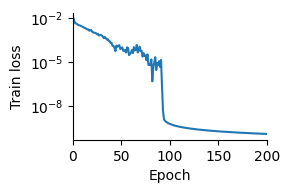

In [27]:
figure(figsize=(3,2))
semilogy(1:n_epoch, error_arr)
ylabel("Train loss"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

In [28]:
X_test, y_test = testset[:];

In [29]:
n_test = length(testset)

10000

In [30]:
size(nn1.W[1].v)

(784, 128)

Dying Relu現象

In [31]:
weight = reshape(nn1.W[1].v', (n_hid, 28, 28));

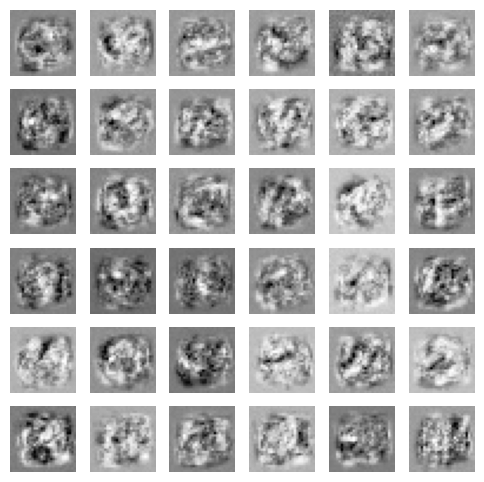

In [32]:
fig, axes = subplots(6, 6, figsize=(6,6))
axf = axes[:]
for i in 1:36#n_hid
    axf[i].imshow(weight[i, :, :], cmap="Greys")
    axf[i].axis("off")
end

In [34]:
"""
for i in 1:5
    subplots()
    imshow(x')
end
"""

"for i in 1:5\n    subplots()\n    imshow(x')\nend\n"

In [33]:
x_test = Matrix(reshape(X_test, (28^2, :))');

In [34]:
y_pred = nn1(x_test);

In [35]:
t_pred = getindex.(argmax(y_pred, dims=2), 2) .- 1;

In [36]:
accuracy = sum(t_pred .== y_test) / n_test * 100

95.49

In [37]:
confusion_matrix = zeros(n_classes, n_classes)
for i in 1:n_test
    confusion_matrix[y_test[i]+1, t_pred[i]+1] += 1
end

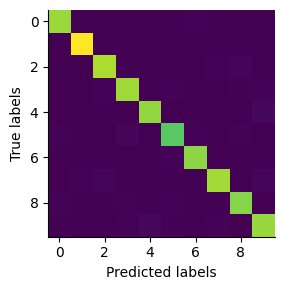

In [38]:
figure(figsize=(3,3))
imshow(confusion_matrix)
xlabel("Predicted labels")
ylabel("True labels")
tight_layout()